# Domain Specific Parsing Expression Grammars
The purpose of this documentation is to provide a high-level tutorial on utilizing parsing
expression grammars for domain-specific language development within Catlab.
This tutorial will provide a brief overview of the PEG.jl library and how it is used.
Additionally, this tutorial will demonstrate a use case of PEG.jl in the context of
parsing a simple language for defining undirected wiring diagrams.

## Developing a Parsing Expression Grammar for Catlab
### PEG.jl
PEG.jl is a parsing expression grammar library for Julia. It allows us to define a grammar
via a macro `@rule`. This allows us to define a formal set of rules for parsing a language.
Let us look at a brief example of how this looks.

First, we import the necessary modules.

In [1]:
using PEG

Next, we define a simple grammar for parsing a language that contains a single word.

In [2]:
@rule simpleGrammar = "hello"

simpleGrammar (generic function with 2 methods)

If we were to parse a string that contained `"hello"` using `parse_whole(simpleGrammar, "hello")`, we would get a successful parse.

Ideally, we want to parse a more complex language than just the word "Hello".
We can utilize the `@rule` macro to create multiple rules nested within each other.
See how this mimics a recursive descent parser?
Let us illustrate this with a simple example: parsing a language that contains a singular function call.

In [3]:
@rule functionCall = identifier & r"\(" & arguments & r"\)"
@rule arguments = (identifier & r"\s*" & r","p)[*] & identifier
@rule identifier = r"[a-zA-Z_][a-zA-Z0-9_]*"

identifier (generic function with 2 methods)

We can read the above grammar left to right and top to bottom.
- We have a function call that expects an identifier followed by an open parenthesis, a list of arguments, and a closing parenthesis.
- The arguments are a list of identifiers separated by commas with optional whitespaces.
- An identifier is a string that starts with a letter or underscore and is followed by letters, numbers, or underscores.

We can also define transformations for our rules that allow us to modify how our parse tree is generated.

Additionally, we can make changes to elements in our parse tree to better suit our needs.
This is illustrated below.

In [4]:
@rule transformationRule = identifier & r"\(" & arguments & r"\)" |> v -> v[1]

transformationRule (generic function with 2 methods)

The above rule will only return the identifier from the function call.
This is done by using the `|>` operator to apply a transformation to the parse tree.
The transformation is a lambda function that takes the parse tree as input and returns the desired output.
We could make a tree more complex by calling functions within our lambda that express semantic analysis.
For more PEG.jl specific syntax, please refer to the [PEG.jl documentation](https://github.com/wdebeaum/PEG.jl)

### Motivation For Developing a PEG for Catlab
The motivation behind developing a parsing expression grammar to support domain specifc languages within Catlab lies in two core reasons:
- To discontinue dependency on Julia metaprogramming for defining domain specific languages.
   - Metaprogramming restricts developers to Julia syntax. This can be limiting when we want DSL features that contradict Julia syntax.
- To provide a simpler way to develop and maintain domain specific languages.
  - PEG.jl provides a more readable and maintainable way to define a grammar.
     - This allows for easier debugging and development of domain specific languages.
  - Reusability of exportable grammar rules means less reinventing the wheel.
     - Less reinventing the wheel means less time spent on development.

### Developing a PEG for Catlab
Core components for developing a domain specific language in Catlab exist in the `Catlab.Parsers` module. `Catlab.Parsers.ParserCore` provides
the core functionality for developing a PEG.

Currently `ParserCore` supports lexical rules as follows:

In [5]:
@rule ws = r"\s*"
@rule eq = r"="p
@rule lparen = r"\("
@rule rparen = r"\)"
@rule comma = r","p
@rule EOL = "\n" , r";"
@rule colon = r":"p
@rule ident = r"[^:{}→\n;=,\(\)\s]+"

ident (generic function with 2 methods)

The above rules allow us to break our string input into tokens.
The above rules can be imported into your parsing expression grammar via: `using Catlab.Parsers.ParserCore`.

`ParserCore` also provides basic syntax for defining a PEG.
For instance, the `expr` rule will parse a Julia expression.

`ParserCore` also provides functions that can be called within transformations:
- `parse_identifier`: Called to properly construct an `ident` into a symbol or integer.
- `collect`: Called to collect a list of elements into a flattened list.

In the future, `ParserCore` will contain more general rules for parsing domain specific languages.
More specific rules are defined in their respective modules within `Catlab.Parsers`.
While `ParserCore` is a work in progress, `Catlab.Parsers.RelationalParser` holds important domain specifc language constructs which we can reuse.
This module contains the parsing expression grammar for building undirected wiring diagrams.
For those who want to get ahead on developing domain specific languages now, `RelationalParser` has core constructs one may copy into their own parsing expression grammar.
Let us illustrate some core PEG rules from `RelationalParser` that offer reusability.

#### Core PEG Rules
`@rule args = (arg & (ws & comma & ws & arg)[*])[:?]  |> v -> collect(v)`

The above rule defines a list of arguments separated by commas.
- It requires lexical rules for whitespace and commas.
- It uses the `collect` function to flatten the list of arguments.
- You will need to define your `arg` rule specific to your language.

`@rule line = ws & statement & r"[^\S\r\n]*" & EOL |> v->v[2]`

The above rule defines a line of code with an undefined statement rule.
The statement rule will depend on what your language allows.
For instance, this might be a function call.

`@rule body = r"{\s*"p & line[*] & r"\n?}"p |> v->v[2]`

The above rule defines a body of code enclosed in braces.

These are the core syntactical constructs that are likely to remain the same across domain specific languages.
By reusing these rules, you can save time and effort in developing your own parsing expression grammar.

## Parsing a Simple Language for Defining Undirected Wiring Diagrams
Now, let's look at a use case of developing a domain specific language for defining undirected wiring diagrams.
First, lets import the necessary modules for this tutorial. GraphViz will need to be installed to output the diagrams.

In [6]:
using Catlab.Parsers, Catlab.WiringDiagrams, Catlab.Graphics

### Basic Language syntax
Our language supports the following syntax:
- We are expected to call our language using the `relation` string macro.
- The first unit in our syntax is the definition of outer ports: `(x, z)`.
- The second unit is the `where` clause: `where (x,y,z)`.
- The third unit is the relations that make up the diagram: `{R(x,y); S(y,z);}`.

Let us look at a few examples of how this language can be used.

### Untyped Undirected Wiring Diagram
In this example, we will parse a simple language for defining an untyped undirected wiring diagram.

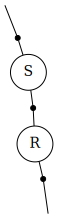

In [7]:
unTypedDiagram = relation"(x,z) where (x,y,z) {R(x,y); S(y,z);}"
to_graphviz(unTypedDiagram, box_labels=:name)

### Typed Undirected Wiring Diagram
Now, let us look at a typed example

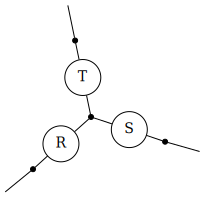

In [8]:
TypedDiagram = relation"(x,y,z) where (x:X, y:Y, z:Z, w:W) {
  R(x,w);
  S(y,w);
  T(z,w);}"
to_graphviz(TypedDiagram, box_labels=:name)

Furthermore, we can generate more complex diagrams with different types.
This domain specific language supports symbol types, integer types, expression types, as well as mixed types.
The above typed diagram illustrated the use of symbol types.

The syntax for integer types is as follows: `x:1`

The syntax for expression types is as follows: `x:n(1)`

The syntax for mixed types is as follows: `x:X, y:1, z:n(1), w:W`

### Named Ports
Undirected Wiring Diagrams may also contain named ports. This motivates our language to support such a feature.
Below is an example of a diagram with named ports.

In [9]:
employeeDirectory = relation"(e=e, e′=e′) where (e:Employee, e′:Employee, d:Department) {
    Employee(id=e, department=d);
    Employee(id=e′, department=d);}"

Catlab.WiringDiagrams.RelationDiagrams.TypedNamedRelationDiagram{Symbol, Symbol, Symbol} {Box:2, Port:4, OuterPort:2, Junction:3, Type:0, Name:0, VarName:0}
┌─────┬──────────┐
│ Box │     name │
├─────┼──────────┤
│   1 │ Employee │
│   2 │ Employee │
└─────┴──────────┘
┌──────┬─────┬──────────┬────────────┬────────────┐
│ Port │ box │ junction │  port_type │  port_name │
├──────┼─────┼──────────┼────────────┼────────────┤
│    1 │   1 │        1 │   Employee │         id │
│    2 │   1 │        3 │ Department │ department │
│    3 │   2 │        2 │   Employee │         id │
│    4 │   2 │        3 │ Department │ department │
└──────┴─────┴──────────┴────────────┴────────────┘
┌───────────┬────────────────┬─────────────────┬─────────────────┐
│ OuterPort │ outer_junction │ outer_port_type │ outer_port_name │
├───────────┼────────────────┼─────────────────┼─────────────────┤
│         1 │              1 │        Employee │               e │
│         2 │              2 │        Employee │              e′ │
└───────────┴────────────────┴─────────────────┴─────────────────┘
┌──────────┬───────────────┬──────────┐
│ Junction │ junction_type │ variable │
├──────────┼───────────────┼──────────┤
│        1 │      Employee │        e │
│        2 │      Employee │       e′ │
│        3 │    Department │        d │
└──────────┴───────────────┴──────────┘

### Infered Context
Our language also supports a context of variables for a undirected wiring diagram.
If the parameters in the `where` clause are omitted, we can infer these.

Below is an example of a diagram with inferred context.

In [10]:
inferredCase = relation"(x,y,z) where () {R(x,y); S(y,z);}"

Catlab.WiringDiagrams.RelationDiagrams.UntypedUnnamedRelationDiagram{Symbol, Symbol} {Box:2, Port:4, OuterPort:3, Junction:3, Name:0, VarName:0}
┌─────┬──────┐
│ Box │ name │
├─────┼──────┤
│   1 │    R │
│   2 │    S │
└─────┴──────┘
┌──────┬─────┬──────────┐
│ Port │ box │ junction │
├──────┼─────┼──────────┤
│    1 │   1 │        1 │
│    2 │   1 │        2 │
│    3 │   2 │        2 │
│    4 │   2 │        3 │
└──────┴─────┴──────────┘
┌───────────┬────────────────┐
│ OuterPort │ outer_junction │
├───────────┼────────────────┤
│         1 │              1 │
│         2 │              2 │
│         3 │              3 │
└───────────┴────────────────┘
┌──────────┬──────────┐
│ Junction │ variable │
├──────────┼──────────┤
│        1 │        x │
│        2 │        y │
│        3 │        z │
└──────────┴──────────┘

### Closed Diagram
Lastly, in the case we want a closed diagram, we simply omit the outer ports in the diagram.
This is illustrated below.

In [11]:
parsed = relation"() where (S:Pop, I:Pop, R:Pop, D:Pop) {
  infect(S,I,I,I)
  disease(I,R)
  disease(I,D);}"

Catlab.WiringDiagrams.RelationDiagrams.TypedUnnamedRelationDiagram{Symbol, Symbol, Symbol} {Box:3, Port:8, OuterPort:0, Junction:4, Type:0, Name:0, VarName:0}
┌─────┬─────────┐
│ Box │    name │
├─────┼─────────┤
│   1 │  infect │
│   2 │ disease │
│   3 │ disease │
└─────┴─────────┘
┌──────┬─────┬──────────┬───────────┐
│ Port │ box │ junction │ port_type │
├──────┼─────┼──────────┼───────────┤
│    1 │   1 │        1 │       Pop │
│    2 │   1 │        2 │       Pop │
│    3 │   1 │        2 │       Pop │
│    4 │   1 │        2 │       Pop │
│    5 │   2 │        2 │       Pop │
│    6 │   2 │        3 │       Pop │
│    7 │   3 │        2 │       Pop │
│    8 │   3 │        4 │       Pop │
└──────┴─────┴──────────┴───────────┘
┌──────────┬───────────────┬──────────┐
│ Junction │ junction_type │ variable │
├──────────┼───────────────┼──────────┤
│        1 │           Pop │        S │
│        2 │           Pop │        I │
│        3 │           Pop │        R │
│        4 │           Pop │        D │
└──────────┴───────────────┴──────────┘